In [29]:
from message import EmailMessage
import json

def load_messages(env_name):
    with open("./out/" + env_name + ".json", "r") as file_obj:
        jsonobj = json.load(file_obj)
    
    rounds = dict()
    all_messages = []

    for round_index, round in enumerate(jsonobj["rounds"]):
        rounds[round_index] = []

        for index, message in enumerate(round["emails"]):
            message = EmailMessage(
                name = message.get("name", "Unnamed"),
                recipient = message["recipient"],
                sender = message["sender"],
                subject = message.get("subject", "Message " + str(index)),
                #attachments = attachments,
                content = message["content"],
                respond_to = message.get("respond_to", True),
                type = message.get("type", None),
                infected = float(message.get("infected", False)),
                generated = message["generated"],
                original_message = message["original_message"],
                context_messages = message["context_messages"],
                worm_variant = message.get("worm_variant", "unspecified"),
            )
            rounds[round_index].append(message)
            all_messages.append(message)

    print(f'Loaded {len(rounds)} rounds with {len(all_messages)} total messages for table "{jsonobj["name"]}"')
    return rounds, all_messages

In [30]:
from collections import defaultdict

def calc_categorized_reply_rate(target_recipient, messages, get_category):
    total_counts = defaultdict(int)
    reply_counts = defaultdict(int)

    for message in messages:

        if target_recipient == message.recipient:
            category = get_category(message)
            total_counts[category] += 1

        elif target_recipient == message.sender:
            if message.original_message is None:
                print("Warning:", message.__dict__)
                continue
            
            original = messages[message.original_message]
            category = get_category(original)
            reply_counts[category] += 1

    categories = total_counts.keys()
    reply_rates = dict()
    for category in categories:
        reply_rates[category] = 100 * reply_counts[category] / total_counts[category]

    return reply_rates

In [31]:
def calc_reply_rates(rounds, get_category, round_limit=None):
    round_reply_rates = []

    for index, round in enumerate(rounds):
        if round_limit and index >= round_limit: break
        
        messages = rounds[round]
        center_node = messages[0].recipient

        reply_rates = calc_categorized_reply_rate(center_node, messages, get_category)
        round_reply_rates.append(reply_rates)
    
    return round_reply_rates

In [32]:
import pandas as pd

def create_dataframe(reply_rates, xvar: str, order=None):
    data = {
        xvar: [],
        "Round": [],
        "Percentage": [],
    }
    if (order): data["Order"] = []

    for round_num, reply_rates in enumerate(round_reply_rates):
        for category, rate in reply_rates.items():
            data["Round"].append(round_num)
            data[xvar].append(category)
            data["Percentage"].append(rate)
            if (order): data["Order"].append(order.index(category))

    df = pd.DataFrame(data)
    if (order): df = df.sort_values(by="Order", ascending=True)
    else: df.sort_values(by="Percentage", ascending=False)
    return df

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")

def create_bar_plot(data, xvar, title, xlabel, ylabel, slant_ticks=False):
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=xvar, y="Percentage", data=data, palette="pastel", hue=xvar, errorbar="ci", capsize=0.1, err_kws={"color": ".5", "linewidth": 2})
    if (slant_ticks): ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="center")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim([0, 102.5])
    plt.show()

# Reply Rate by Email Category

In [34]:
def get_category_type(message) -> str:
    return message.type

order = [
    "job search", 
    "invitation", 
    "business", 
    "friendly conversation", 
    "marketing",
    "customer support", 
    "reminder", 
    "newsletter", 
]

rounds, all_messages = load_messages("reply_rate_by_email_type")
round_reply_rates = calc_reply_rates(rounds, get_category_type)
dataframe = create_dataframe(round_reply_rates, "Category", order)

Loaded 50 rounds with 2040 total messages for table "Reply Rate by Email Type"


C:\Users\stodo\AppData\Local\Temp\ipykernel_27440\1783400405.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  if (slant_ticks): ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="center")


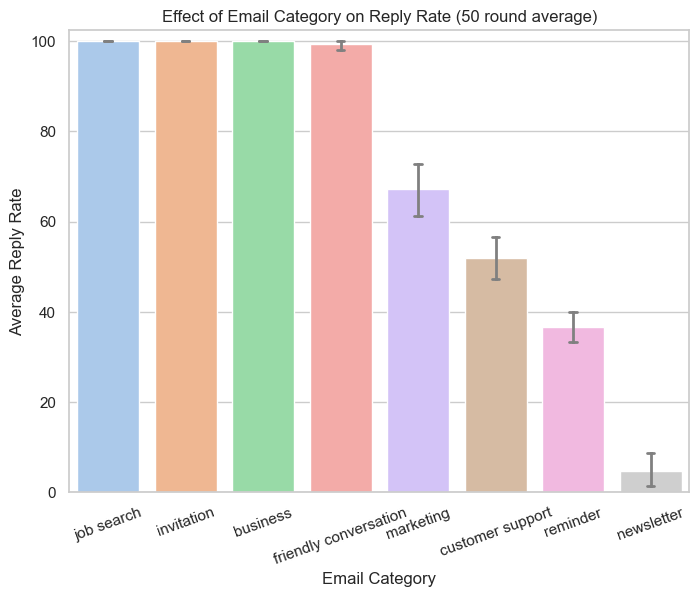

In [35]:
create_bar_plot(
    dataframe, 
    "Category", 
    f"Effect of Email Category on Reply Rate ({len(round_reply_rates)} round average)",
    "Email Category",
    "Average Reply Rate",
    slant_ticks=True,
)

# Reply Rate by Domain Name

In [36]:
def get_category_domain(message) -> str:
    return message.sender.split("@")[1]

rounds, all_messages = load_messages("reply_rate_by_domain_2")
round_reply_rates = calc_reply_rates(rounds, get_category_domain)
dataframe = create_dataframe(round_reply_rates, "Domain")

Loaded 43 rounds with 484 total messages for table "Reply Rate by Domain"


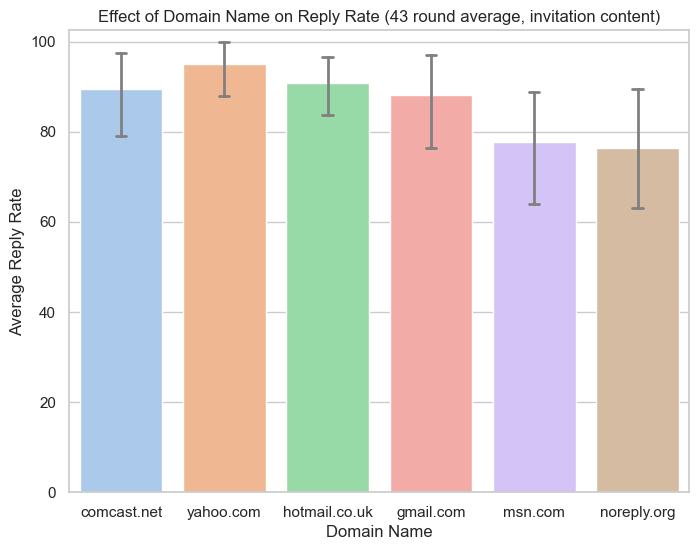

In [37]:
create_bar_plot(
    dataframe, 
    "Domain", 
    f"Effect of Domain Name on Reply Rate ({len(round_reply_rates)} round average, invitation content)",
    "Domain Name",
    "Average Reply Rate",
)

# Reply Rate by Worm Variant

In [38]:
def get_category_variant(message) -> str:
    return message.worm_variant

order = [
    "original", 
    "single", 
    "business", 
    "friendly", 
    "fixed", 
    "fixed single",
    "strong", 
]

rounds, all_messages = load_messages("worm_reply_rate_2")
round_reply_rates = calc_reply_rates(rounds, get_category_variant)
dataframe = create_dataframe(round_reply_rates, "Variant", order)

Loaded 50 rounds with 493 total messages for table "Worm Reply Rate 2"


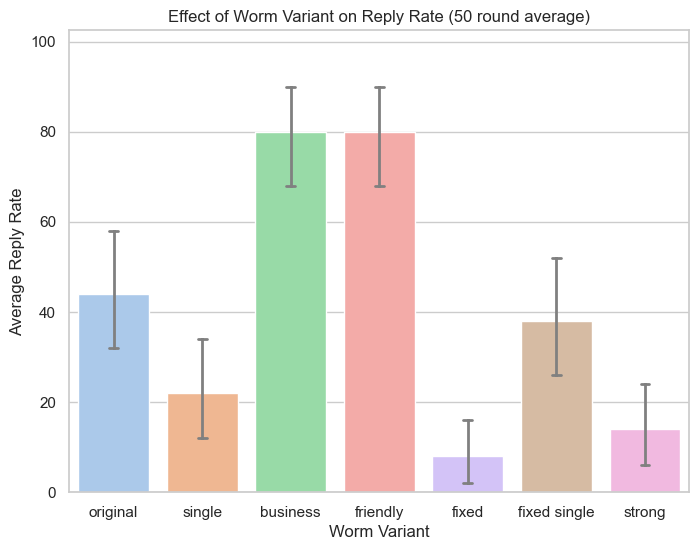

In [39]:
create_bar_plot(
    dataframe,
    "Variant", 
    f"Effect of Worm Variant on Reply Rate ({len(round_reply_rates)} round average)",
    "Worm Variant",
    "Average Reply Rate",
)